## Load Datasets 

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [35]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import time


In [36]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import sys 
from tensorflow import keras 
from keras.models import Sequential 
from keras.applications.vgg16 import VGG16

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split

from zipfile import ZipFile
import os
import sys

sys.path.insert(0, "../lib")
#import keras.applications
from resnet import load_resnet, ResNet18
#from lossFunctions import get_custom_cross_entropy, l1_loss


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if not os.path.exists("./drive"):
    drive.mount('/content/drive')

if not os.path.exists("../data"):
    os.mkdir("../data")

# loading the temp.zip and creating a zip object
with ZipFile("./drive/MyDrive/train_data.zip", 'r') as zip_object:

    # Extracting all the members of the zip 
    # into a specific location.
    zip_object.extractall(path="../data")


### Data Preprocessing 

In [ ]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    #img_fn
    img_fn = f'../data/images/{i+1:05d}.png'
    #img_fn=f'/content/drive/MyDrive/ads_proj3/fall2022-project3-prj3-group3/data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

Class: <class 'numpy.ndarray'>
Dimensions: (32, 32, 3)
Data Type: uint8
Head: [[[63 62 59]
  [45 46 43]
  [43 48 50]]

 [[20 20 16]
  [ 0  0  0]
  [ 0  8 18]]

 [[21 24 25]
  [ 0  7 16]
  [ 8 27 49]]]
Range 0 255


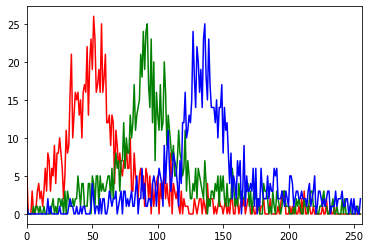

In [ ]:
# example of data info 
#file_path = "train_data\\images\\00001.png"
file_path="../data/images/00001.png"
img = cv2.imread(file_path)
print('Class:', type(img))
print('Dimensions:', img.shape)
print('Data Type:', img.dtype)
print('Head:', img[:3, :3])
print('Range', np.min(img), np.max(img))

color = ('r', 'g','b')
for i, col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


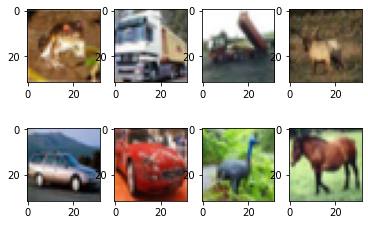

In [ ]:
# [DO NOT MODIFY THIS CELL]

# visualize
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## Predictive Model 
We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### Baseline Model: Logistic Regression 

In [ ]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [ ]:
feature_mtx
# len(feature_mtx)

array([[ 19., 102., 619., ...,  84.,  42.,  15.],
       [ 98., 301., 233., ..., 316., 200., 146.],
       [127., 405., 130., ..., 105.,  37., 306.],
       ...,
       [450., 268., 106., ..., 117.,  78., 285.],
       [ 45.,  80., 278., ..., 166., 291., 434.],
       [ 55., 193., 376., ..., 364., 150., 165.]])

In [ ]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [ ]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

# DATASET

In [53]:
# Assign Required Variables
X_train = tf.cast(imgs[10000:], dtype='float32')/255.0
y_train = tf.one_hot(noisy_labels, depth=10)
y_train_noisy=  tf.one_hot(noisy_labels[10000:], depth=10)
X_test = tf.cast(imgs[:10000], dtype='float32')/255.0
X_test_img = imgs[:10000]
y_test = tf.one_hot(clean_labels, depth = 10)

In [ ]:
aug = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

# Model I: CNN

In [69]:
model1_cnn = keras.Sequential([ 
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), 
                        strides=1, padding='same',
                        input_shape=(32,32,3), use_bias=False), 
    # keras.layers.BatchNormalization(), 
    keras.layers.Activation('relu'), 
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid'), 
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), 
                       strides=1, padding='same', use_bias=False), 
    # keras.layers.BatchNormalization(), 
    keras.layers.Activation('relu'), 
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid'), 
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), 
                       strides=1, padding='same', use_bias=False), 
    keras.layers.Activation('relu'), 
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid'), 
    keras.layers.Dropout(0.2), 
    
    keras.layers.Flatten(), 
    keras.layers.Dense(64, use_bias=False), 
    keras.layers.Activation('relu'), 
    keras.layers.Dense(10, activation='softmax') 
]) 



In [70]:
# categorical cross entropy due to one hot
model1_cnn.compile(optimizer = tf.keras.optimizers.Adam(0.001),
             loss = tf.keras.losses.CategoricalCrossentropy(),
             metrics = ['accuracy'])

In [72]:
%%time 

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True,monitor='loss')
mod1_cnn=model1_cnn.fit(aug.flow(X_train, y_train_noisy, batch_size = 256),epochs=100, callbacks=[early_stopping])


Epoch 1/100
157/157 [==============================] - 17s 105ms/step - loss: 2.2537 - accuracy: 0.1769
Epoch 2/100
157/157 [==============================] - 17s 105ms/step - loss: 2.2445 - accuracy: 0.1875
Epoch 3/100
157/157 [==============================] - 17s 105ms/step - loss: 2.2322 - accuracy: 0.1992
Epoch 4/100
157/157 [==============================] - 17s 106ms/step - loss: 2.2262 - accuracy: 0.2061
Epoch 5/100
157/157 [==============================] - 17s 105ms/step - loss: 2.2152 - accuracy: 0.2160
Epoch 6/100
157/157 [==============================] - 17s 106ms/step - loss: 2.2101 - accuracy: 0.2216
Epoch 7/100
157/157 [==============================] - 17s 106ms/step - loss: 2.2041 - accuracy: 0.2278
Epoch 8/100
157/157 [==============================] - 18s 114ms/step - loss: 2.1992 - accuracy: 0.2328
Epoch 9/100
157/157 [==============================] - 17s 106ms/step - loss: 2.1934 - accuracy: 0.2370
Epoch 10/100
157/157 [==============================] - 17s 106m

In [73]:
model1_cnn.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.6410 - accuracy: 0.5629


[1.6409988403320312, 0.5629000067710876]

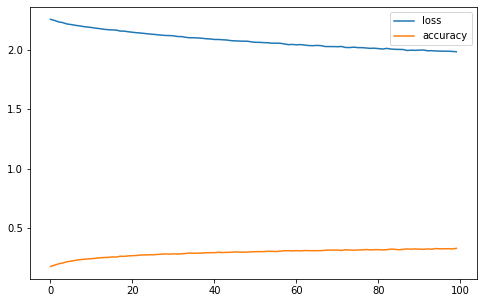

In [77]:
pd.DataFrame(mod1_cnn.history).plot(figsize=(8,5))

# Model 1: VGG16

In [78]:
vgg = VGG16(input_shape=(32,32,3), include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [80]:
vgg.trainable = False
model_vgg = keras.Sequential([
    vgg, 
    keras.layers.GlobalAveragePooling2D(), 
    keras.layers.Dense(10, activation='softmax')    
])


In [81]:
# categorical cross entropy due to one hot
model_vgg.compile(optimizer = tf.keras.optimizers.Adam(0.001),
             loss = tf.keras.losses.CategoricalCrossentropy(),
             metrics = ['accuracy'])

In [85]:
%%time 

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True,monitor='loss')
vgg_mod=model_vgg.fit(aug.flow(X_train, y_train_noisy, batch_size = 256),epochs=100, callbacks=[early_stopping])


Epoch 1/100
157/157 [==============================] - 18s 114ms/step - loss: 2.1856 - accuracy: 0.2439
Epoch 2/100
157/157 [==============================] - 18s 115ms/step - loss: 2.1831 - accuracy: 0.2453
Epoch 3/100
157/157 [==============================] - 18s 114ms/step - loss: 2.1813 - accuracy: 0.2468
Epoch 4/100
157/157 [==============================] - 18s 113ms/step - loss: 2.1794 - accuracy: 0.2475
Epoch 5/100
157/157 [==============================] - 18s 114ms/step - loss: 2.1791 - accuracy: 0.2462
Epoch 6/100
157/157 [==============================] - 18s 113ms/step - loss: 2.1768 - accuracy: 0.2482
Epoch 7/100
157/157 [==============================] - 18s 113ms/step - loss: 2.1766 - accuracy: 0.2470
Epoch 8/100
157/157 [==============================] - 18s 113ms/step - loss: 2.1769 - accuracy: 0.2469
Epoch 9/100
157/157 [==============================] - 18s 115ms/step - loss: 2.1736 - accuracy: 0.2500
Epoch 10/100
157/157 [==============================] - 19s 119m

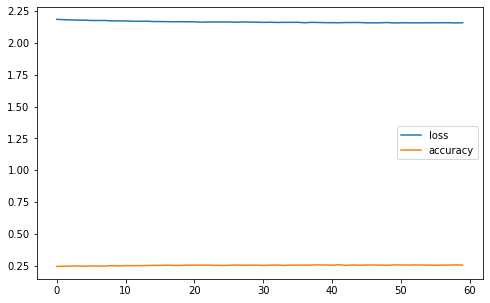

In [90]:
pd.DataFrame(vgg_mod.history).plot(figsize=(8,5))

In [89]:
model_vgg.evaluate(X_test,y_test)

313/313 [==============================] - 4s 10ms/step - loss: 1.7533 - accuracy: 0.5252


[1.7533310651779175, 0.5252000093460083]

# MODEL 1: RESNET 18

ResNet-18 is a convolutional neural network that is 18 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. 

As Resnet18 does not have an equivalent version in keras. We defined resnet 18 through its architecture in resnet.py and pretrained using weights from 9000 clean labels that we have and left 1000 for testing. 

In [39]:
from resnet import load_resnet, ResNet18
ResNet18.trainable=False

In [40]:
resnet_18=ResNet18(10)
resnet_18.build(input_shape=(None,32,32,3))

In [41]:
resnet_18.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=['accuracy'])

In [50]:
%%time
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True,monitor='loss')

resn_model=resnet_18.fit(aug.flow(X_train, y_train_noisy, batch_size = 256),epochs=100, callbacks=[early_stopping])
                         
                     

Epoch 1/100
157/157 [==============================] - 26s 163ms/step - loss: 2.2417 - accuracy: 0.1966
Epoch 2/100
157/157 [==============================] - 23s 145ms/step - loss: 2.2299 - accuracy: 0.2061
Epoch 3/100
157/157 [==============================] - 23s 149ms/step - loss: 2.2202 - accuracy: 0.2116
Epoch 4/100
157/157 [==============================] - 26s 163ms/step - loss: 2.2120 - accuracy: 0.2175
Epoch 5/100
157/157 [==============================] - 23s 149ms/step - loss: 2.2026 - accuracy: 0.2239
Epoch 6/100
157/157 [==============================] - 20s 125ms/step - loss: 2.1987 - accuracy: 0.2300
Epoch 7/100
157/157 [==============================] - 27s 169ms/step - loss: 2.1895 - accuracy: 0.2384
Epoch 8/100
157/157 [==============================] - 27s 169ms/step - loss: 2.1838 - accuracy: 0.2419
Epoch 9/100
157/157 [==============================] - 25s 160ms/step - loss: 2.1804 - accuracy: 0.2444
Epoch 10/100
157/157 [==============================] - 20s 125m

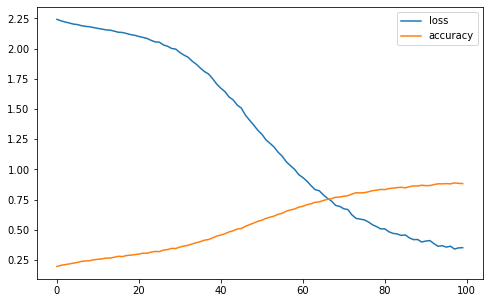

In [66]:
pd.DataFrame(resn_model.history).plot(figsize=(8,5))

In [58]:
resnet_18.evaluate(X_test,y_test)

313/313 [==============================] - 3s 10ms/step - loss: 3.6190 - accuracy: 0.3103


[3.618980884552002, 0.31029999256134033]

# EVALUATION TABLE

In [91]:
# import module
from tabulate import tabulate
 
# assign data
mydata = [
    ["CNN","0.3289","17s","0.5629"],
    ["VGG", "0.2564" ,"18s","0.5252"],
    ["Resnet-18", "0.8828","19s","0.3102"],
 
]
 
# create header
head = ["Model Name","Highest Training Accuracy", "Avg Time per epoch", "Test accuracy"]

 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+--------------+-----------------------------+----------------------+-----------------+
| Model Name   |   Highest Training Accuracy | Avg Time per epoch   |   Test accuracy |
+==============+=============================+======================+=================+
| CNN          |                      0.3289 | 17s                  |          0.5629 |
+--------------+-----------------------------+----------------------+-----------------+
| VGG          |                      0.2564 | 18s                  |          0.5252 |
+--------------+-----------------------------+----------------------+-----------------+
| Resnet-18    |                      0.8828 | 19s                  |          0.3102 |
+--------------+-----------------------------+----------------------+-----------------+


## Conclusion
We select Resnet-18 our Model 1